**SERVICIO EDUCACIONAL HOGAR Y SALUD DEL NORTE**

**INDICADOR: Ingreso mensual generado por sede**


Christian Ovalle

In [ ]:
!pip install --upgrade pip
!pip install numpy==1.25.2
!pip install pandas==2.1.1
!pip install catboost

  Using cached pandas-2.1.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached pandas-2.1.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.1.1 which is incompatible.
mizani 0.13.3 requires pandas>=2.2.0, but you have pandas 2.1.1 which is incompatible.
plotnine 0.14.5 requires pandas>=2.2.0, but you have pandas 2.1.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 54.4 MB/s eta 0:00:00


In [ ]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings("ignore")

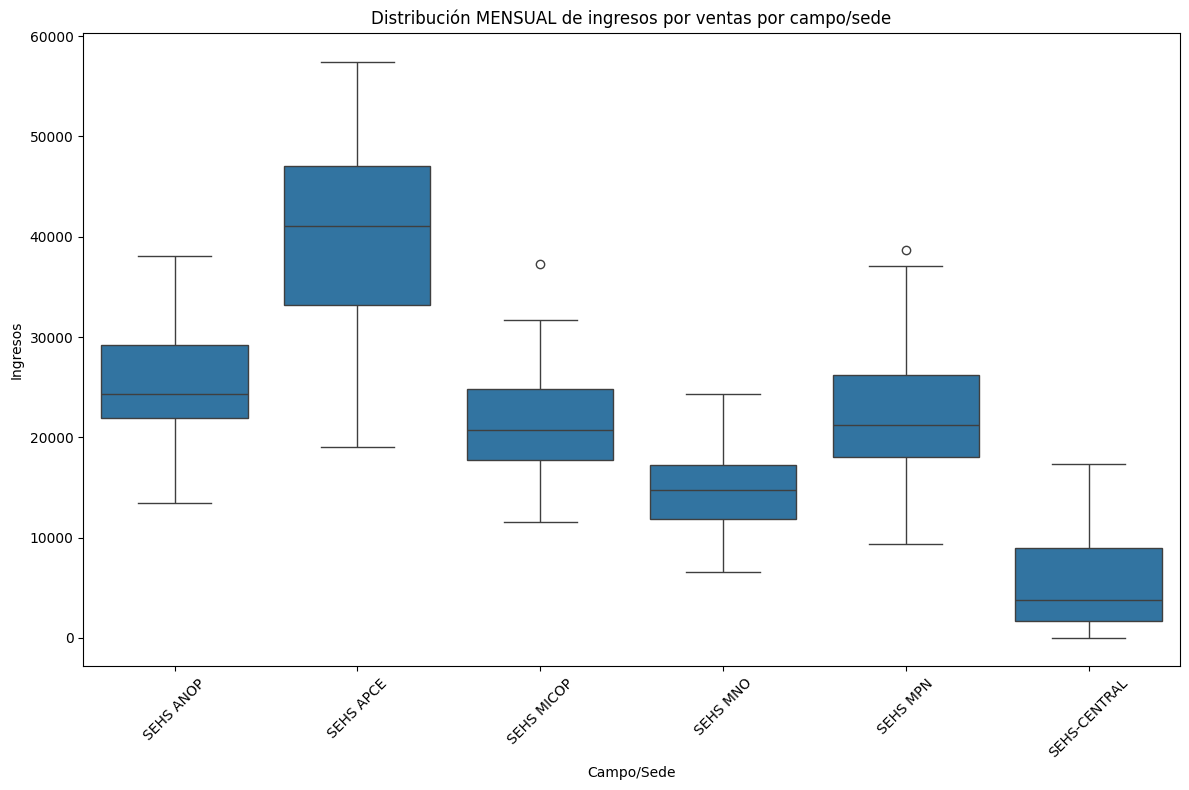

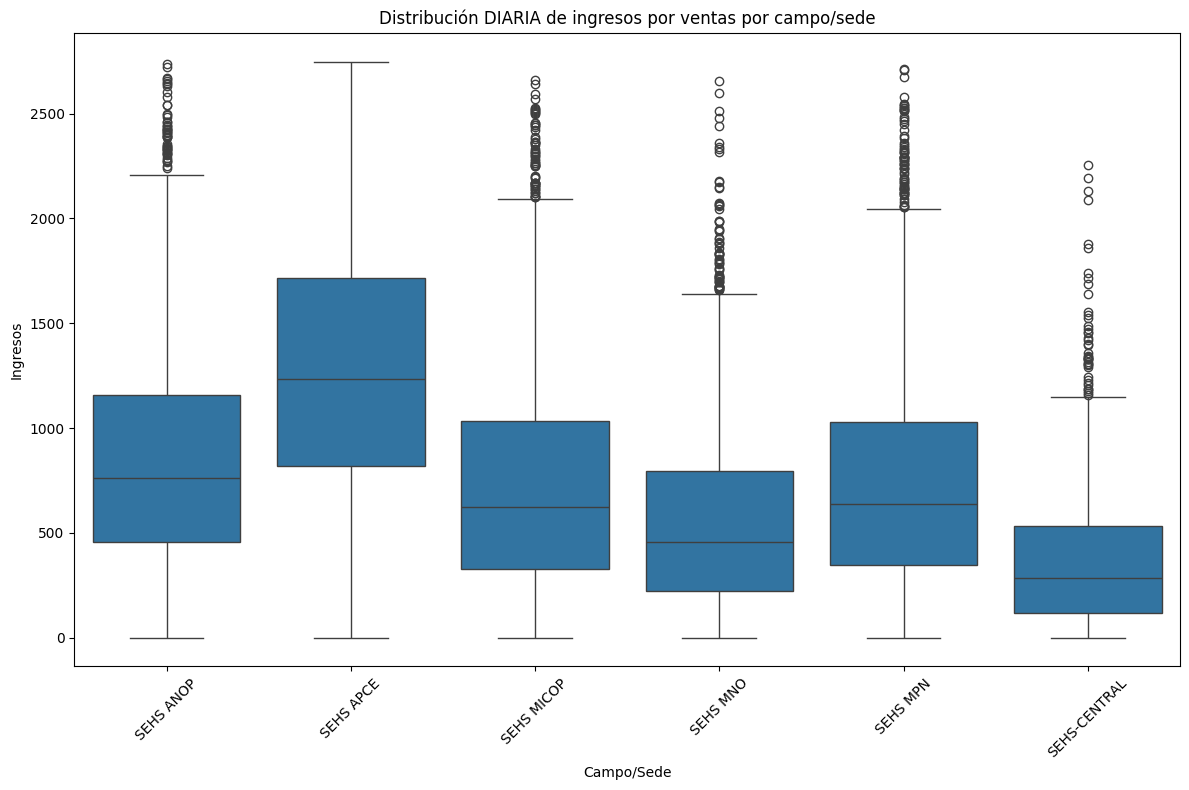

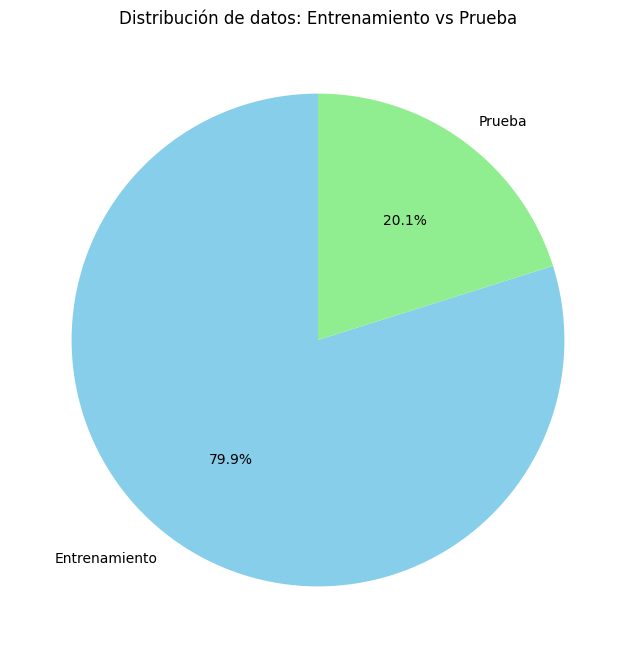

In [ ]:
# Cargar el dataset
file_path = "/content/Datasets_Base_familias.xlsx"
dataset = pd.read_excel(file_path)
sedes_validas = ['SEHS ANOP', 'SHES APCE', 'SEHS MICOP', 'SEHS MNO', 'SEHS MPN', 'SEHS CENTRAL']
dataset = dataset[dataset['campo'].isin(sedes_validas)]

# --- ANÁLISIS MENSUAL ---
# Preparación de los datos
data = pd.DataFrame()
data['campo'] = dataset['campo']
data['sum_precio'] = dataset['Suma de precio']
data['fecha'] = dataset['fecha'].dt.to_period('M')  # Agrupamiento mensual

# Agrupar las ventas por campo y mes
df_sum_campo = data.groupby(['campo', 'fecha'])['sum_precio'].sum().reset_index()
df_sum_campo['sum_precio'] = df_sum_campo['sum_precio'].round()
df_sum_campo['fecha'] = pd.to_datetime(df_sum_campo['fecha'].astype(str), format='%Y-%m')

# --- ANÁLISIS DIARIO  ---
# Preparación de datos diarios
data_diario = pd.DataFrame()
data_diario['campo'] = dataset['campo']  # Mismo campo que en tu original
data_diario['sum_precio'] = dataset['Suma de precio']  # Mismo campo de precios
data_diario['fecha'] = dataset['fecha'].dt.normalize()  # Fecha diaria sin hora

# Agrupar por día
df_diario = data_diario.groupby(['campo', 'fecha'])['sum_precio'].sum().reset_index()
df_diario['sum_precio'] = df_diario['sum_precio'].round()

# --- MANEJO DE OUTLIERS ---
# Para mensual
z_scores = zscore(df_sum_campo['sum_precio'])
df_sum_campo = df_sum_campo[(np.abs(z_scores) < 3)]

# Para diario
z_scores_diario = zscore(df_diario['sum_precio'])
df_diario = df_diario[(np.abs(z_scores_diario) < 3)]

# --- GRÁFICO MENSUAL ---
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_sum_campo, x='campo', y='sum_precio')
plt.title('Distribución MENSUAL de ingresos por sede')
plt.xlabel('Sede')
plt.ylabel('Ingresos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- GRÁFICO DIARIO ---
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_diario, x='campo', y='sum_precio')
plt.title('Distribución DIARIA de ingresos por sede')
plt.xlabel('Sede')
plt.ylabel('Ingresos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Convertir las categorías a variables dummy (USANDO LOS DATOS MENSUALES)
df_encoded = pd.get_dummies(df_sum_campo, columns=['campo'])
df_encoded['Year'] = df_encoded['fecha'].dt.year
df_encoded['Month'] = df_encoded['fecha'].dt.month

# Lista única de categorías
campos = df_sum_campo['campo'].unique()

# Filtrar los datos para el entrenamiento y validación
df_train = df_encoded[df_encoded['Year'] < 2024]
df_test = df_encoded[df_encoded['Year'] >= 2020]

# Definir características (X) y objetivo (y)
X = df_train.drop(columns=['sum_precio', 'fecha'])
y = df_train['sum_precio']

# Definir X_test con las mismas columnas que X
X_test = df_test[X.columns]
y_test = df_test['sum_precio']

# Division aleatoria de los datos para el entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalamiento de las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Visualización de la división de datos
division_labels = ['Entrenamiento', 'Prueba']
division_sizes = [len(X_train), len(X_test)]

plt.figure(figsize=(8, 8))
plt.pie(division_sizes, labels=division_labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'])
plt.title('Distribución de datos: Entrenamiento vs Prueba')
plt.show()

In [ ]:
# 2. Configuración del modelo de stacking
def build_stacking_model():
    estimators = [
        ('gb', GradientBoostingRegressor()),
        ('catboost', CatBoostRegressor(verbose=0, random_seed=42, loss_function='RMSE')),
        ('rf', RandomForestRegressor())
    ]
    stacking_model = StackingRegressor(
        estimators=estimators,
        final_estimator=LinearRegression(),
        cv=5
    )
    return stacking_model

In [ ]:
# 3. ENTRENAMIENTO DE LOS MODELOS BASE
stacking_model = build_stacking_model()
stacking_model.fit(X_train_scaled, y_train)

StackingRegressor(cv=5,
                  estimators=[('gb', GradientBoostingRegressor()),
                              ('catboost',
                               <catboost.core.CatBoostRegressor object at 0x78f9057ac890>),
                              ('rf', RandomForestRegressor())],
                  final_estimator=LinearRegression())

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros encontrados:
{'rf__n_estimators': 50, 'rf__min_samples_split': 20, 'rf__max_depth': 20, 'gb__n_estimators': 150, 'gb__min_samples_split': 10, 'gb__max_depth': 20, 'gb__learning_rate': 0.1, 'catboost__learning_rate': 0.1, 'catboost__iterations': 250, 'catboost__depth': 5}


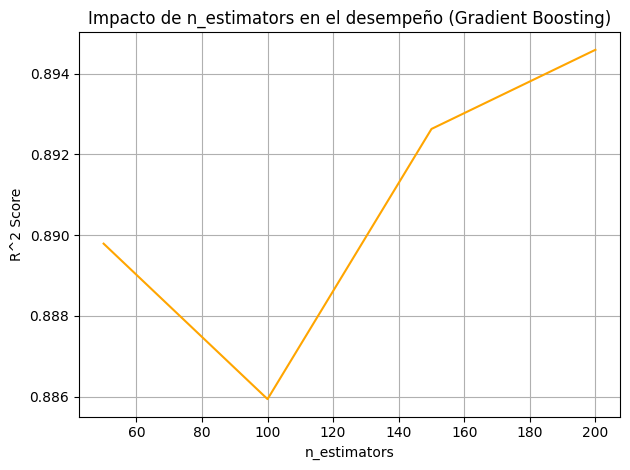

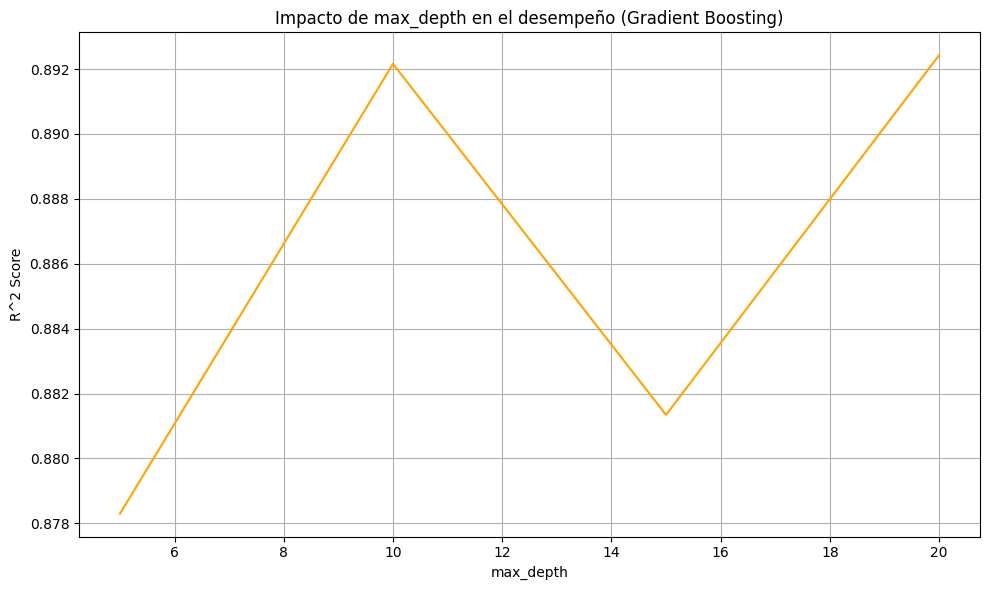

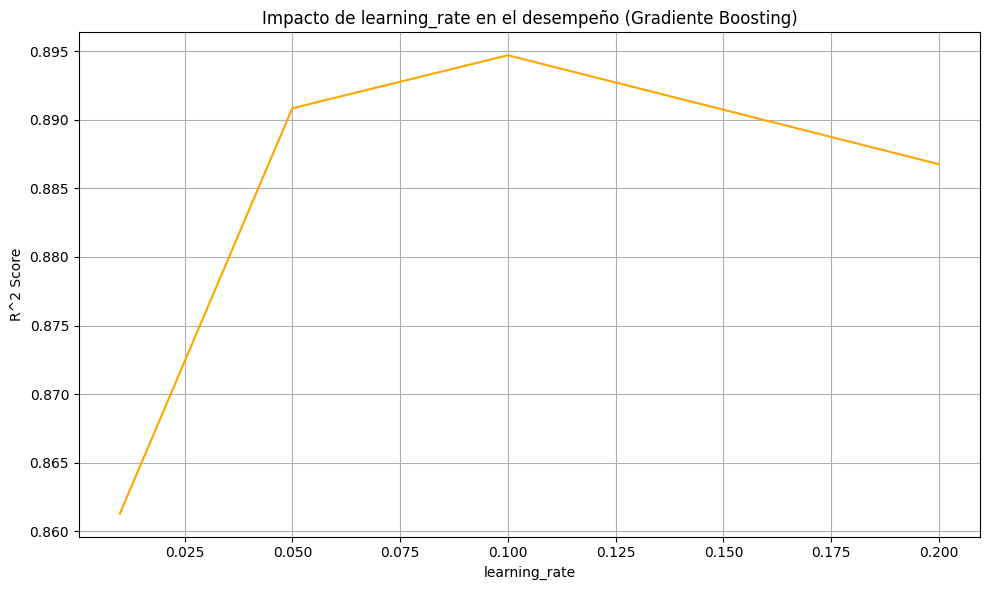

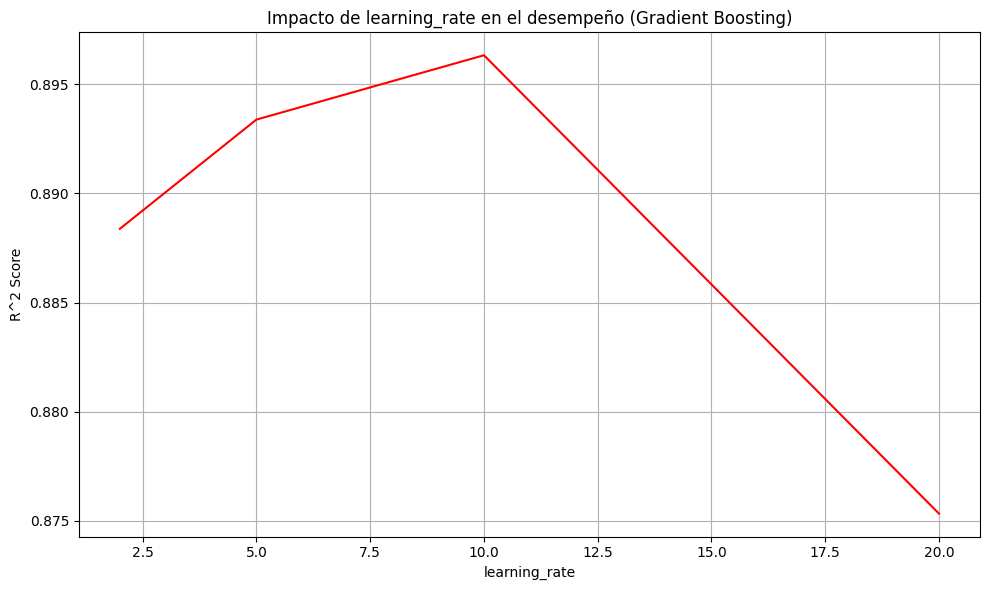

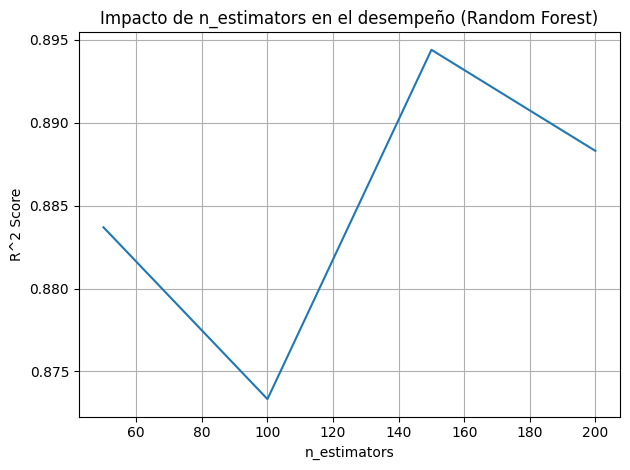

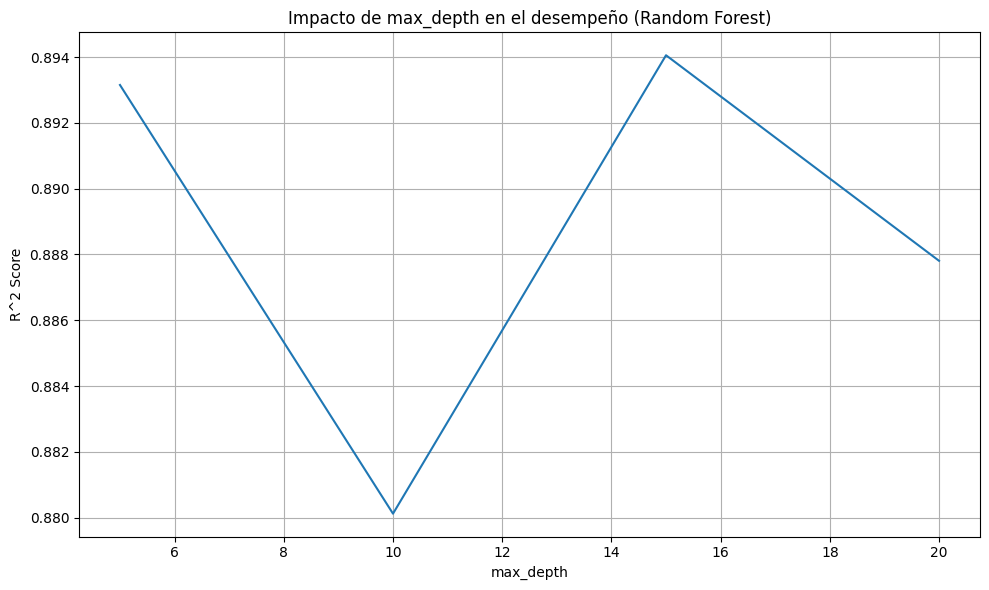

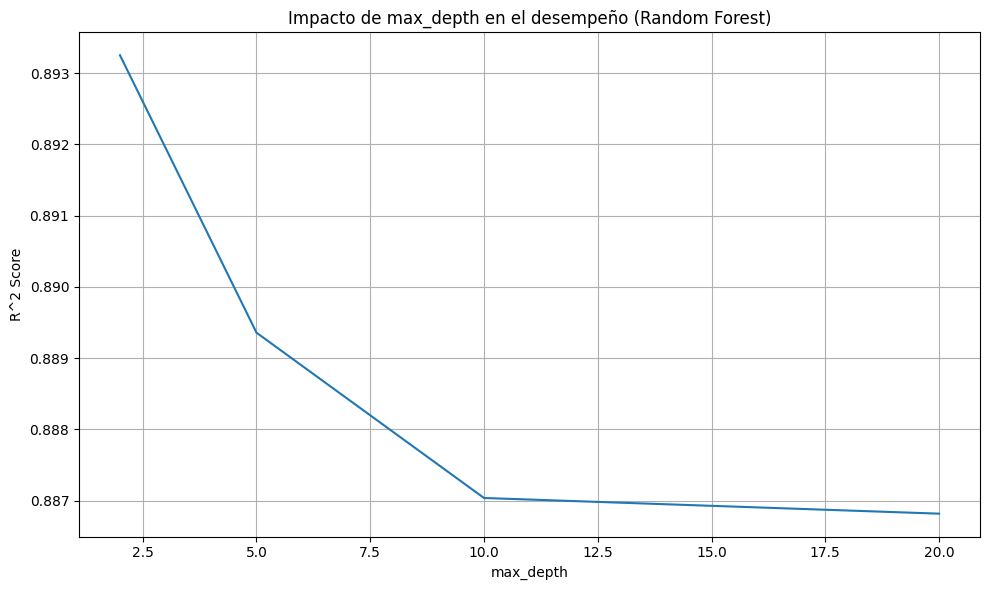

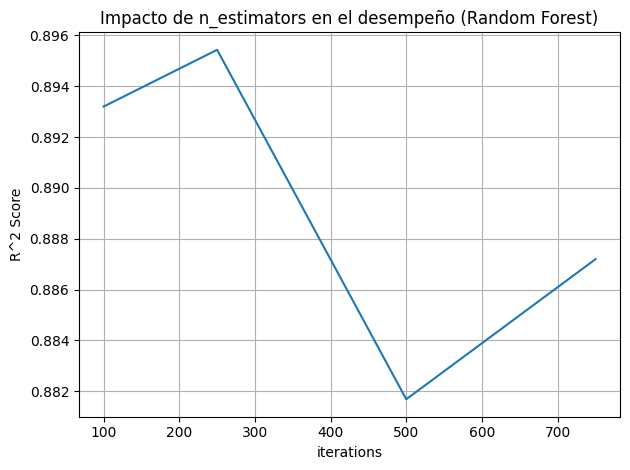

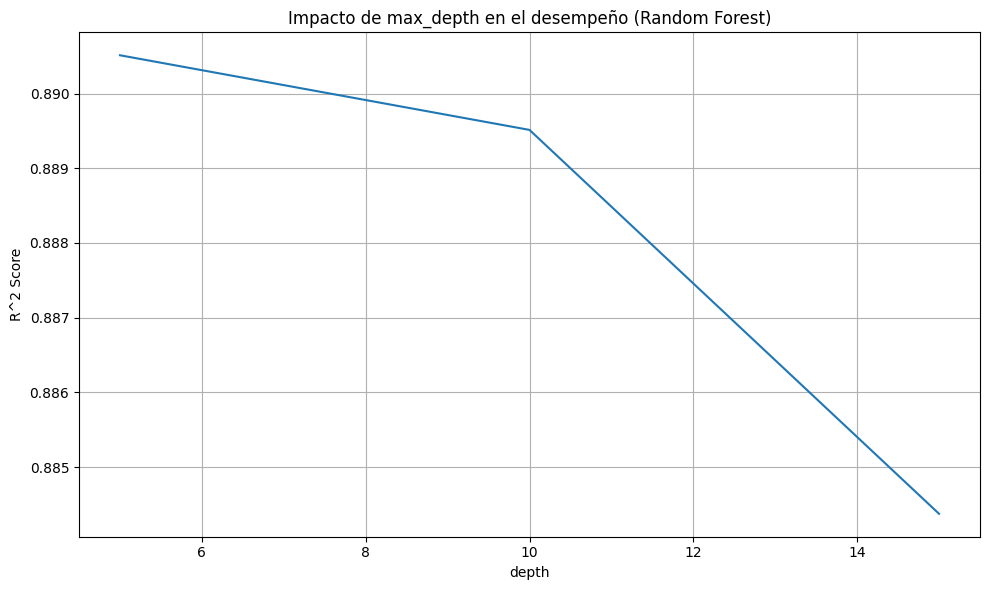

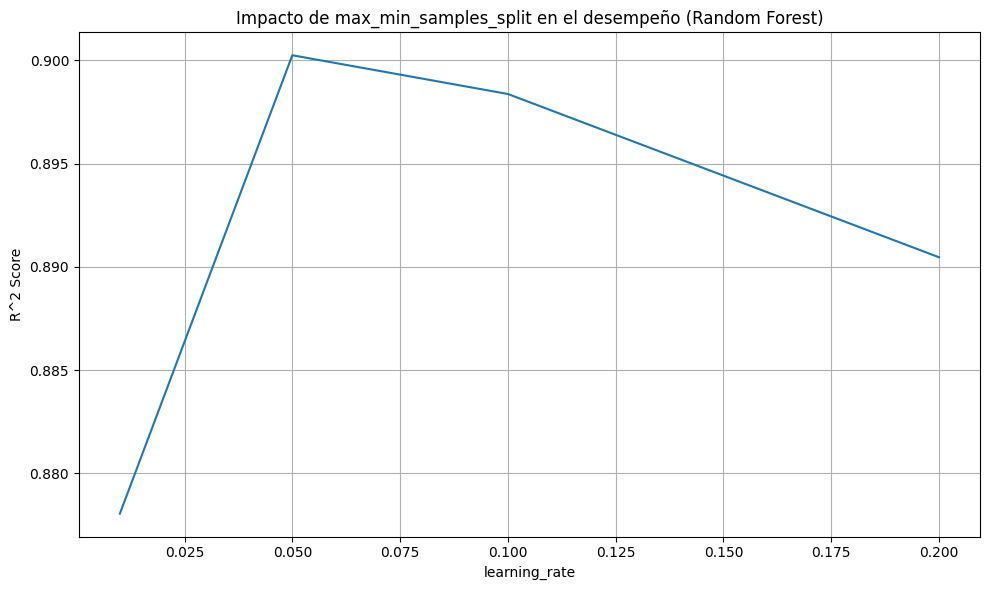

In [ ]:
# 4. OPTIMIZACIÓN DE LOS HIPERPARÁMETROS
param_grid = {
    'catboost__iterations': [100, 250, 500, 750],
    'catboost__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'catboost__depth': [5, 10, 15, 20],
    "gb__n_estimators": [50, 100, 150, 200],
    "gb__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "gb__max_depth": [5, 10, 15, 20],
    "gb__min_samples_split": [2, 5, 10,20],
    "rf__n_estimators": [50, 100, 150, 200],
    "rf__max_depth": [5, 10, 15, 20],
    "rf__min_samples_split": [2, 5, 10, 20]
}
random_search = RandomizedSearchCV(
    estimator=build_stacking_model(),
    param_distributions=param_grid,
    scoring='r2',
    n_iter=20,
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train_scaled, y_train)
best_model = random_search.best_estimator_

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Resultados del ajuste de hiperparámetros
results = pd.DataFrame(random_search.cv_results_)

# Gráficas de la iteración de los hiperparámetros con respecto a R^2

#Para GradientBoosting
xgb_results = results[["param_gb__n_estimators", "param_gb__learning_rate", "param_gb__max_depth", "param_gb__min_samples_split", "mean_test_score"]]

sns.lineplot(x="param_gb__n_estimators", y="mean_test_score", data=xgb_results, errorbar=None, color='orange')
plt.title("Impacto de n_estimators en el desempeño (Gradient Boosting)")
plt.xlabel("n_estimators")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="param_gb__max_depth", y="mean_test_score", data=xgb_results, errorbar= None, color='orange')
plt.title("Impacto de max_depth en el desempeño (Gradient Boosting)")
plt.xlabel("max_depth")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="param_gb__learning_rate", y="mean_test_score", data=xgb_results, errorbar= None,color='orange')
plt.title("Impacto de learning_rate en el desempeño (Gradiente Boosting)")
plt.xlabel("learning_rate")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="param_gb__min_samples_split", y="mean_test_score", data=xgb_results, errorbar= None,color='red')
plt.title("Impacto de learning_rate en el desempeño (Gradient Boosting)")
plt.xlabel("learning_rate")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

# Para Random Forest
rf_results = results[["param_rf__n_estimators", "param_rf__max_depth", "param_rf__min_samples_split", "mean_test_score"]]

# Gráfico para n_estimators
sns.lineplot(x="param_rf__n_estimators", y="mean_test_score", data=rf_results, errorbar= None)
plt.title("Impacto de n_estimators en el desempeño (Random Forest)")
plt.xlabel("n_estimators")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

# Gráfico para max_depth
plt.figure(figsize=(10, 6))
sns.lineplot(x="param_rf__max_depth", y="mean_test_score", data=rf_results, errorbar= None)
plt.title("Impacto de max_depth en el desempeño (Random Forest)")
plt.xlabel("max_depth")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

# Gráfico para min_samples_split
plt.figure(figsize=(10, 6))
sns.lineplot(x="param_rf__min_samples_split", y="mean_test_score", data=rf_results, errorbar= None)
plt.title("Impacto de max_depth en el desempeño (Random Forest)")
plt.xlabel("max_depth")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()


# Para Catboost
catboost_results = results[["param_catboost__iterations", "param_catboost__depth", "param_catboost__learning_rate", "mean_test_score"]]

sns.lineplot(x="param_catboost__iterations", y="mean_test_score", data=catboost_results, errorbar= None)
plt.title("Impacto de n_estimators en el desempeño (Random Forest)")
plt.xlabel("iterations")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="param_catboost__depth", y="mean_test_score", data=catboost_results, errorbar= None)
plt.title("Impacto de max_depth en el desempeño (Random Forest)")
plt.xlabel("depth")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="param_catboost__learning_rate", y="mean_test_score", data=catboost_results, errorbar= None)
plt.title("Impacto de max_min_samples_split en el desempeño (Random Forest)")
plt.xlabel("learning_rate")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()



In [ ]:
# 5. FORMACIÓN DEL STACK
best_model.fit(X_train_scaled, y_train)

StackingRegressor(cv=5,
                  estimators=[('gb',
                               GradientBoostingRegressor(max_depth=20,
                                                         min_samples_split=10,
                                                         n_estimators=150)),
                              ('catboost',
                               <catboost.core.CatBoostRegressor object at 0x78f9059f6750>),
                              ('rf',
                               RandomForestRegressor(max_depth=20,
                                                     min_samples_split=20,
                                                     n_estimators=50))],
                  final_estimator=LinearRegression())

In [ ]:
# 6. PREDICCIÓN DEL STACK
y_pred = best_model.predict(X_test_scaled)

Métricas para Gradient Boosting:
  Mean Squared Error (MSE): 0.0043
  R^2 Score: 0.9016
  Mean Absolute Error (MAE): 0.0479
  Root Mean Squared Error (RMSE): 0.0653

Métricas para CatBoost:
  Mean Squared Error (MSE): 0.0042
  R^2 Score: 0.9034
  Mean Absolute Error (MAE): 0.0494
  Root Mean Squared Error (RMSE): 0.0648

Métricas para Random Forest:
  Mean Squared Error (MSE): 0.0045
  R^2 Score: 0.8973
  Mean Absolute Error (MAE): 0.0499
  Root Mean Squared Error (RMSE): 0.0668

Métricas del Stacking (Salida del Meta-modelo):
  Mean Squared Error (MSE): 0.0038
  R^2 Score: 0.9117
  Root Mean Squared Error (RMSE): 0.0619
  Mean Absolute Error (MAE): 0.0451



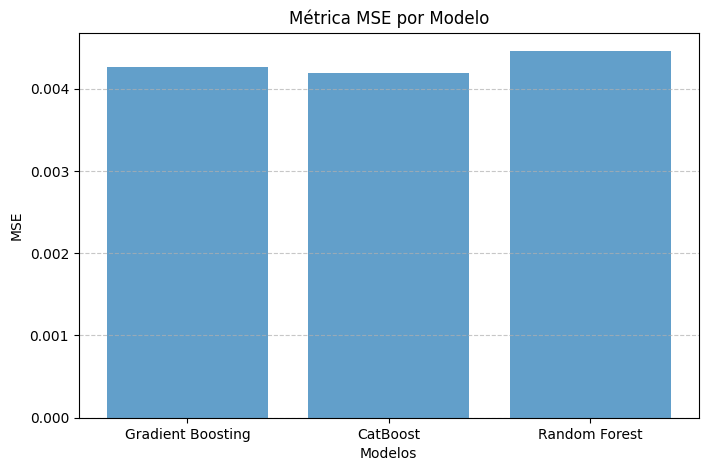

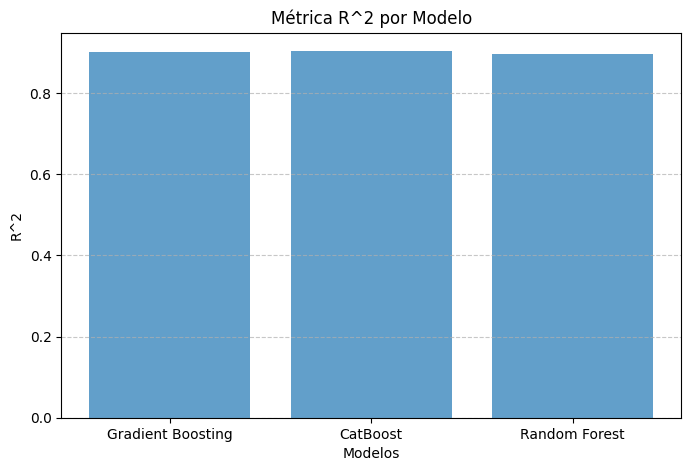

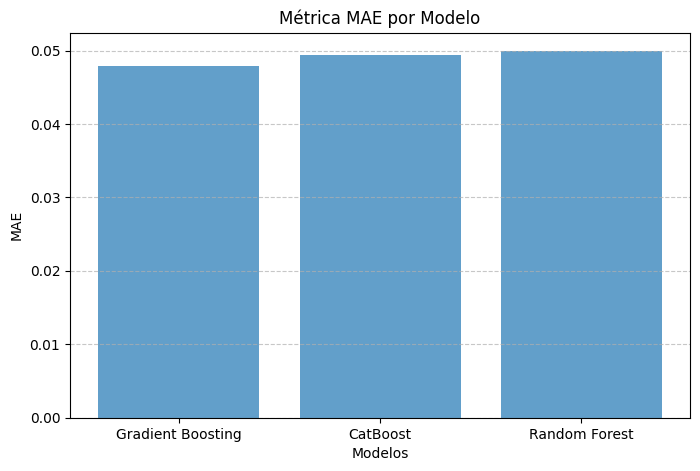

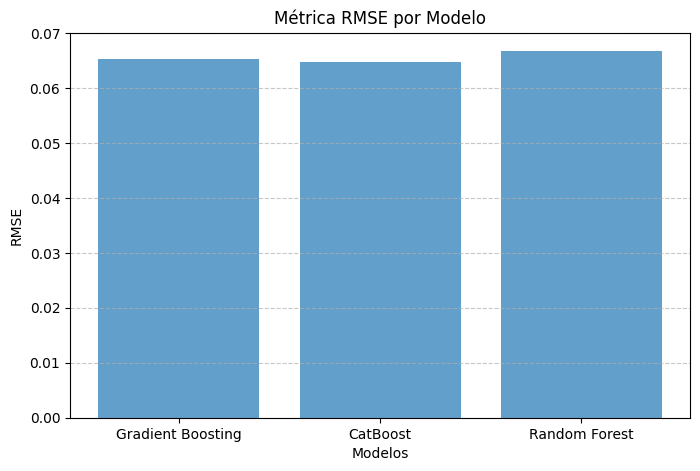

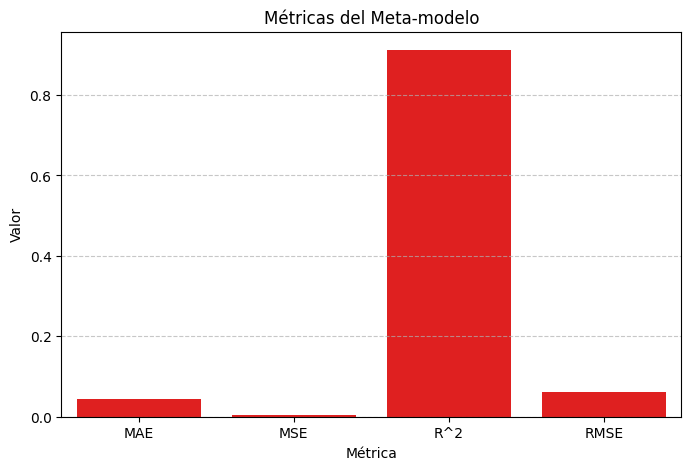


     Actual     Predicted
0      2654   3990.614896
1       988    183.556355
2     30215  25402.333275
3       179  -1206.991258
4     15907  11797.312983
..      ...           ...
109   20817  19487.830947
110     552   -281.850897
111   28839  25311.522303
112   28834  30400.688801
113    8071   7920.261407

[114 rows x 2 columns]



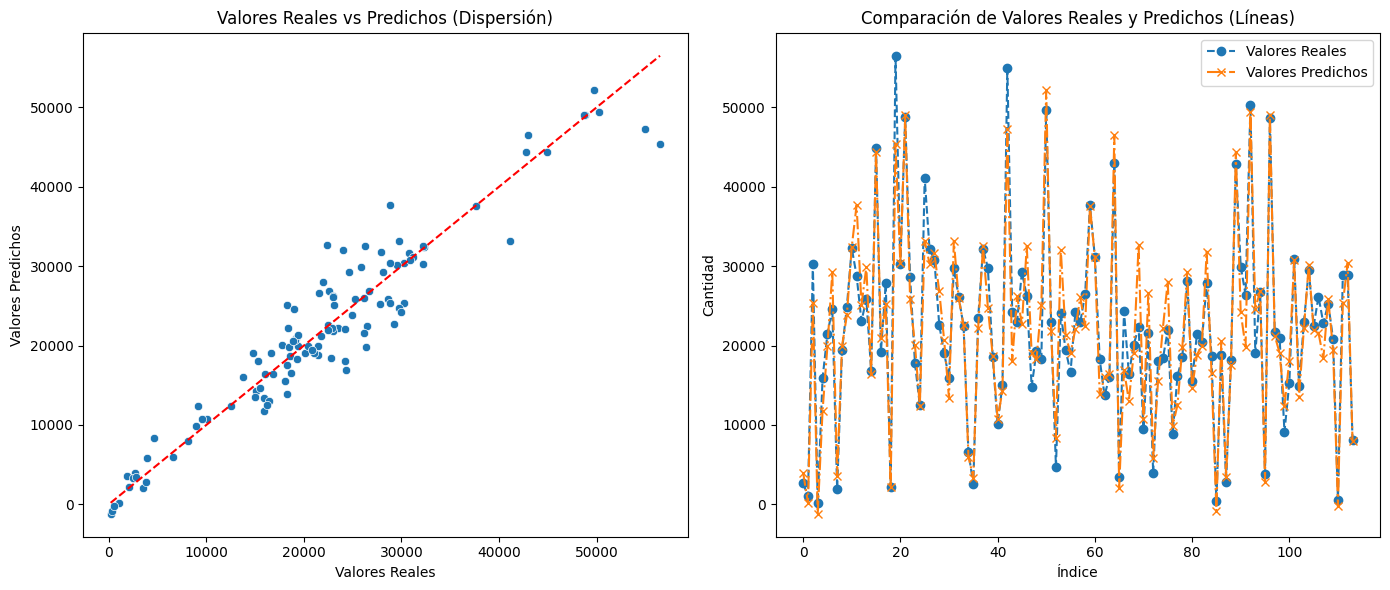

In [ ]:
# 7. Métricas de evaluación
# Métricas de cada modelo base
base_models = {
    'Gradient Boosting': stacking_model.named_estimators_['gb'],
    'CatBoost': stacking_model.named_estimators_['catboost'],
    'Random Forest': stacking_model.named_estimators_['rf']
}

# Calcular métricas para cada modelo base
model_metrics = {}
for model_name, model in base_models.items():
    y_pred_base = model.predict(X_test_scaled)
    mse_base = mean_squared_error(y_test, y_pred_base)
    mse_normalizado = mse_base / ((y_test.max() - y_test.min())**2)
    r2_base = r2_score(y_test, y_pred_base)
    mae_base = mean_absolute_error(y_test, y_pred_base)
    mae_normalizado = mae_base / (y_test.max() - y_test.min())
    rmse_base = np.sqrt(mse_base)
    rmse_normalizado = rmse_base / (y_test.max() - y_test.min())

    print(f"Métricas para {model_name}:")
    print(f"  Mean Squared Error (MSE): {mse_normalizado:.4f}")
    print(f"  R^2 Score: {r2_base:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae_normalizado:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse_normalizado:.4f}\n")

    model_metrics[model_name] = {
        'MSE': mse_normalizado,
        'R^2': r2_base,
        'MAE': mae_normalizado,
        'RMSE': rmse_normalizado
    }

# Métricas de evaluación de la salida del Stacking (Salida del Meta-modelo)
meta_mse = mean_squared_error(y_test, y_pred)
meta_r2 = r2_score(y_test, y_pred)
meta_mae = mean_absolute_error(y_test, y_pred)
meta_rmse = np.sqrt(meta_mse)

# Normalizar las métricas de la salida del Stacking
meta_mse_normalizado = meta_mse / ((y_test.max() - y_test.min())**2)
meta_rmse_normalizado = meta_rmse / (y_test.max() - y_test.min())
meta_mae_normalizado = meta_mae / (y_test.max() - y_test.min())
meta_metricas = {'MAE':meta_mae_normalizado, 'MSE':meta_mse_normalizado, 'R^2':meta_r2, 'RMSE':meta_rmse_normalizado}

# Mostrar las métricas del Stacking
print("Métricas del Stacking (Salida del Meta-modelo):")
print(f"  Mean Squared Error (MSE): {meta_mse_normalizado:.4f}")
print(f"  R^2 Score: {meta_r2:.4f}")
print(f"  Root Mean Squared Error (RMSE): {meta_rmse_normalizado:.4f}")
print(f"  Mean Absolute Error (MAE): {meta_mae_normalizado:.4f}\n")


# Gráficas de las métricas de los modelos base
metrics = ['MSE', 'R^2', 'MAE', 'RMSE'] # Fixed indentation here
for metric in metrics:
    values = [model_metrics[model][metric] for model in model_metrics]
    plt.figure(figsize=(8, 5))
    plt.bar(model_metrics.keys(), values, alpha=0.7)
    plt.title(f'Métrica {metric} por Modelo')
    plt.ylabel(metric)
    plt.xlabel('Modelos')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Dataframe para las metricas del Stacking (Salida del meta-modelo)
meta_metricas_df = pd.DataFrame({
    'Métrica': ['MAE', 'MSE', 'R^2', 'RMSE'],
    'Valor': [meta_mae_normalizado, meta_mse_normalizado, meta_r2, meta_rmse_normalizado]
})

meta_metricas_df = pd.DataFrame(list(meta_metricas.items()), columns=['Métrica', 'Valor'])

# Graficar las metricas del Stacking
plt.figure(figsize=(8, 5))
sns.barplot(x='Métrica', y='Valor', data=meta_metricas_df, errorbar=None, color='red')
plt.title('Métricas del Meta-modelo')
plt.ylabel('Valor')
plt.xlabel('Métrica')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Comparar los valores reales vs predichos
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).reset_index(drop=True)
print()
print(comparison)
print()

# Configurar las gráficas
plt.figure(figsize=(14, 6))

# Gráfico de dispersión
plt.subplot(1, 2, 1)
sns.scatterplot(x=comparison['Actual'], y=comparison['Predicted'])
plt.plot([comparison['Actual'].min(), comparison['Actual'].max()],
         [comparison['Actual'].min(), comparison['Actual'].max()],
         color='red', linestyle='--')
plt.title('Valores Reales vs Predichos (Dispersión)')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')

# Gráfico de líneas
plt.subplot(1, 2, 2)
plt.plot(comparison['Actual'].values, label='Valores Reales', marker='o', linestyle='--')
plt.plot(comparison['Predicted'].values, label='Valores Predichos', marker='x', linestyle='-.')
plt.title('Comparación de Valores Reales y Predichos (Líneas)')
plt.xlabel('Índice')
plt.ylabel('Cantidad')
plt.legend()

plt.tight_layout()
plt.show()

     Year  Actual  Predicted      fecha         campo
12   2017   22647    24274.0 2017-01-01     SEHS ANOP
13   2017   19705    18007.0 2017-02-01     SEHS ANOP
14   2017   22754    21412.0 2017-03-01     SEHS ANOP
15   2017   26170    21867.0 2017-04-01     SEHS ANOP
16   2017   21039    22966.0 2017-05-01     SEHS ANOP
..    ...     ...        ...        ...           ...
566  2023    3476     1935.0 2023-08-01  SEHS-CENTRAL
567  2023    3772     2516.0 2023-09-01  SEHS-CENTRAL
568  2023    3161     3075.0 2023-10-01  SEHS-CENTRAL
569  2023    3257     3335.0 2023-11-01  SEHS-CENTRAL
570  2023    3022     2807.0 2023-12-01  SEHS-CENTRAL

[495 rows x 5 columns]
    Year         campo   Actual  Predicted
0   2017     SEHS ANOP  25555.0    25233.0
1   2017     SEHS APCE  37533.0    38353.0
2   2017    SEHS MICOP  19949.0    20058.0
3   2017      SEHS MNO  17633.0    16896.0
4   2017      SEHS MPN  15305.0    16066.0
5   2017  SEHS-CENTRAL  14104.0    12905.0
6   2018     SEHS ANOP  266

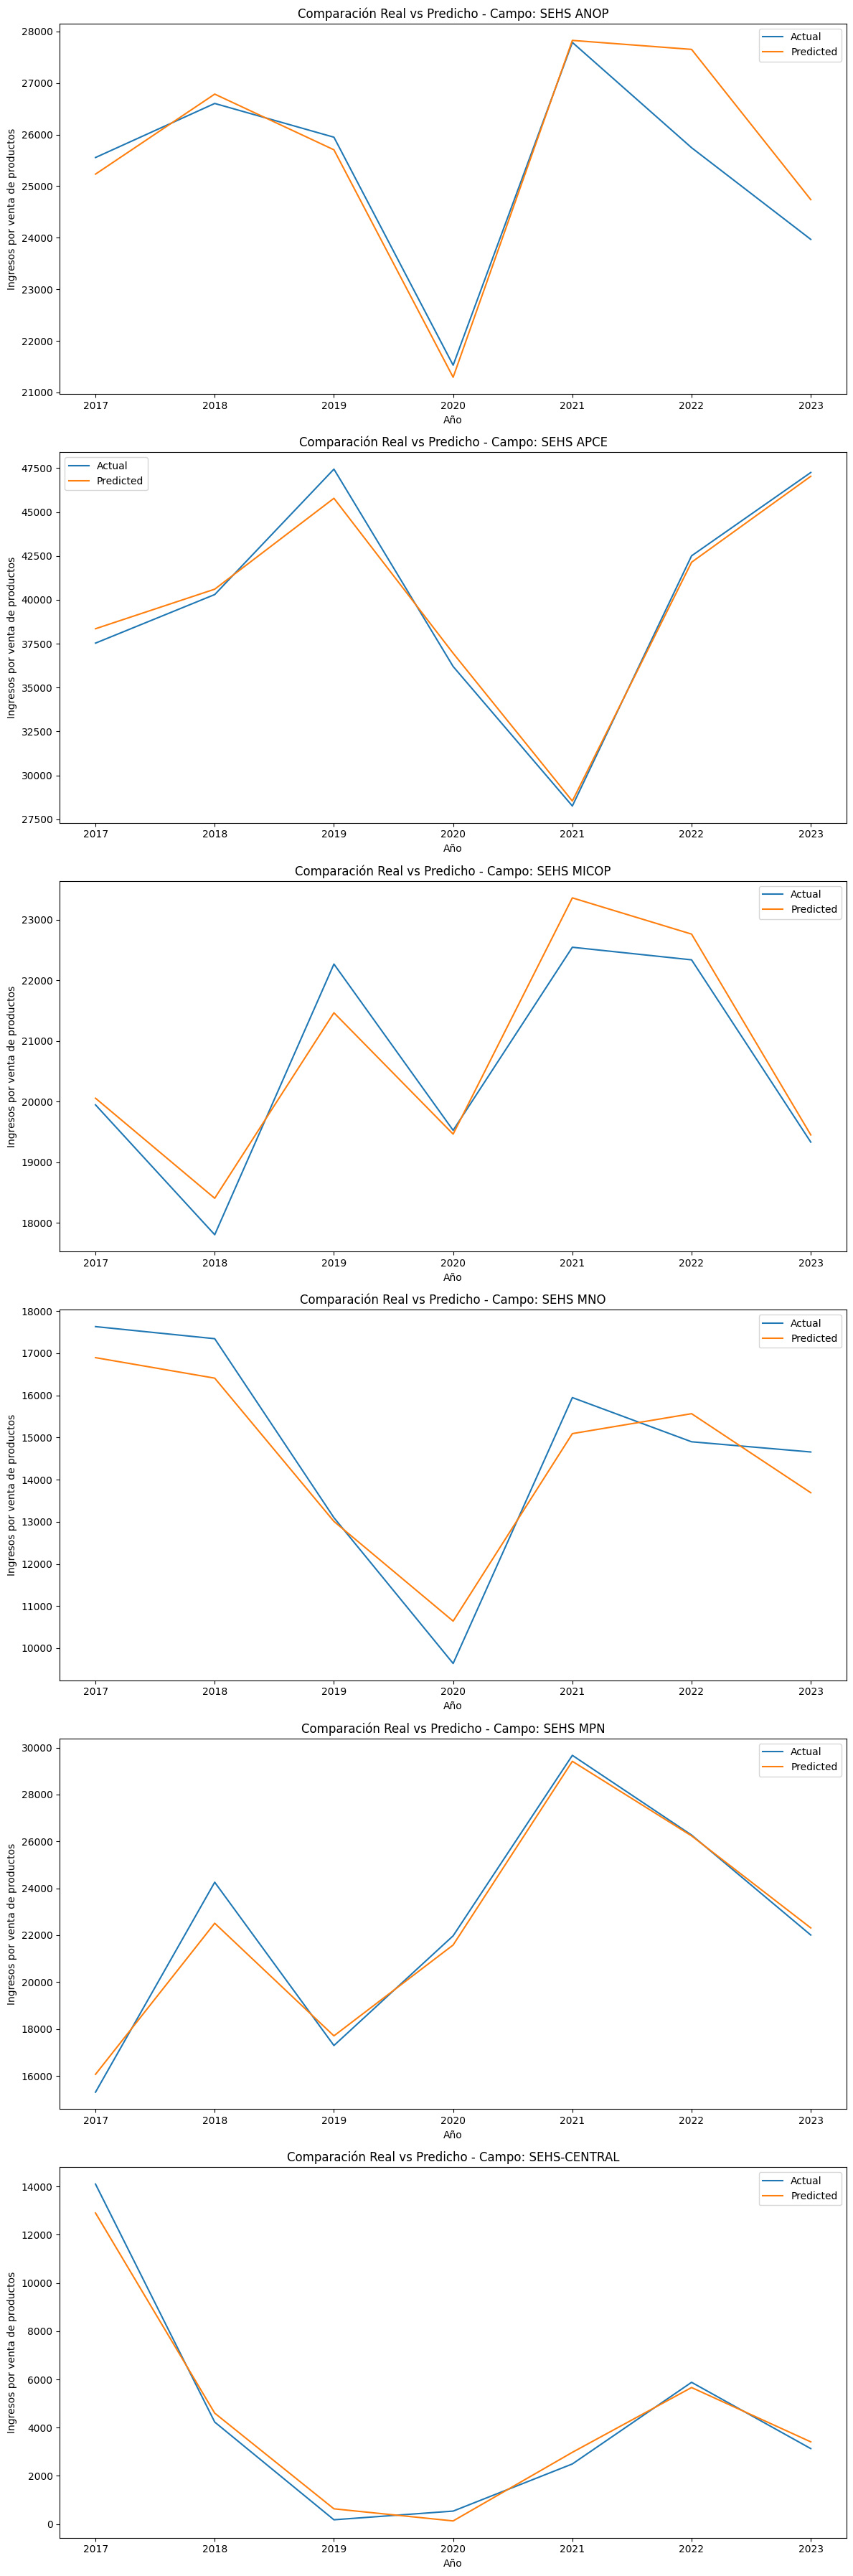

In [ ]:
df_test['campo_Original'] = None

campos_cols = [col for col in df_test.columns if col.startswith('campo_')]

for idx, row in df_test.iterrows():
    for col in campos_cols:
        if row[col] == 1:
            df_test.at[idx, 'campo_Original'] = col.replace('campo_', '')
            break

df_sum_campo['campo_Original'] = df_sum_campo['campo']

years = range(2017, 2024)
comparison_results = []

for year in years:
    df_year = df_encoded[df_encoded['Year'] == year]
    X_test = df_year.drop(columns=['sum_precio', 'fecha'])
    y_test = df_year['sum_precio']

    # Escalar datos de prueba
    X_test_scaled = scaler.transform(X_test)
    y_pred = stacking_model.predict(X_test_scaled)

    # Almacenar resultados
    comparison = pd.DataFrame({
        'Year': [year] * len(y_test),
        'Actual': y_test,
        'Predicted': y_pred
    })
    comparison = pd.merge(comparison, df_sum_campo[df_sum_campo['fecha'].dt.year == year][['fecha','campo']], left_index=True, right_index=True, how='left')
    comparison_results.append(comparison)

# Unir todos los resultados
final_comparison = pd.concat(comparison_results).round(0)
print(final_comparison)

final_comparison.to_excel('predicciones_comparacion_abastecimiento3.xlsx', index=False)

# Calcular cantidad promedio real y predicha por año y campo
avg_comparison = final_comparison.groupby(['Year', 'campo']).agg({
    'Actual': 'mean',
    'Predicted': 'mean'
}).reset_index().round(0)

print(avg_comparison)


# Graficar comparaciones por año y campo
campos = df_sum_campo['campo'].unique()
fig, axes = plt.subplots(nrows=len(campos), figsize=(12, 6 * len(campos)))

for i, campo in enumerate(campos):
    campo_data = final_comparison[final_comparison['campo'] == campo]

    sns.lineplot(data=campo_data, x='Year', y='Actual', label='Actual', ax=axes[i], errorbar=None)
    sns.lineplot(data=campo_data, x='Year', y='Predicted', label='Predicted', ax=axes[i], errorbar=None)

    axes[i].set_title(f'Comparación Real vs Predicho - Campo: {campo}')
    axes[i].set_xlabel('Año')
    axes[i].set_ylabel('Ingresos por venta de productos')

plt.tight_layout()
plt.show()

# **PREDICCIÓN PARA EL AÑO 2024**

        fecha  Ingreso de Ventas_predicho
0  2024-01-01                32664.659422
1  2024-02-01                25454.683410
2  2024-03-01                19828.305318
3  2024-04-01                18445.314006
4  2024-05-01                19487.830947
..        ...                         ...
67 2024-08-01                 2029.385507
68 2024-09-01                 2844.755818
69 2024-10-01                 3285.809781
70 2024-11-01                 3558.746844
71 2024-12-01                 3140.925229

[72 rows x 2 columns]


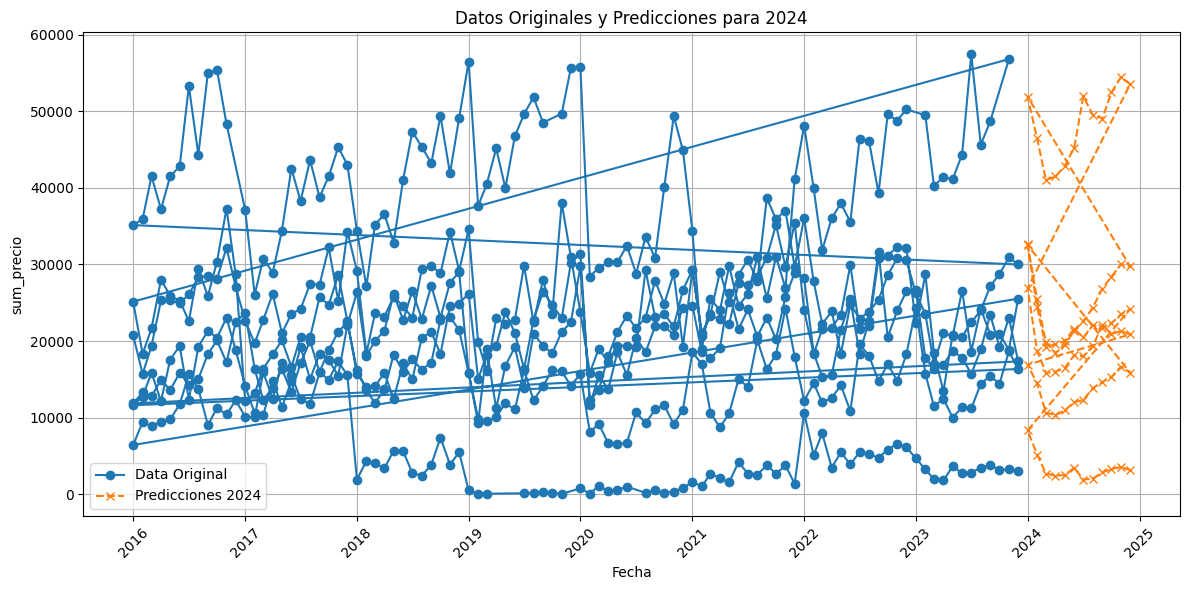

In [ ]:
# Crear datos futuros para el año 2024
unique_campos = df_sum_campo['campo'].unique()
future_dates = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS')

# Crear una lista para almacenar los datos futuros de cada campo
all_future_data = []

# Recorre cada «campo» único para crear datos para 2024 campo in unique_campos:
for campo in unique_campos:
    future_data = pd.DataFrame({
        'fecha': pd.to_datetime(future_dates),
        'Year': future_dates.year,
        'Month': future_dates.month,
        'campo': campo
    })
    all_future_data.append(future_data)

# Concatenar todos los datos futuros en un solo DataFrame
future_data = pd.concat(all_future_data, ignore_index=True)

# Obtener las columnas originales utilizadas durante el entrenamiento (asumiendo que se utilizó X_train_scaled)
original_columns = X_train.columns

# Crear variables dummy para la columna 'campo' y alinearlas con las columnas originales
future_data = pd.get_dummies(future_data, columns=['campo'], prefix=['campo'], prefix_sep='_')

# Asegurarse de que future_data tenga las mismas columnas que los datos originales
missing_cols = set(original_columns) - set(future_data.columns)  # Identificar las columnas que faltan
for col in missing_cols:
    future_data[col] = 0

# Reordenar las columnas para que coincidan con las columnas originales, manteniendo la columna 'fecha'
future_data_reordered = future_data[original_columns]
future_data['Ingreso de Ventas_predicho'] = best_model.predict(scaler.transform(future_data_reordered))
future_results = future_data[['fecha', 'Ingreso de Ventas_predicho']]

# Predecir los ingresos por ventas utilizando el mejor modelo y escalar los datos futuros antes de predecir
future_data['Ingreso de Ventas_predicho'] = best_model.predict(scaler.transform(future_data_reordered))

# Crear un DataFrame con las columnas 'fecha' y 'Ingreso de Ventas_predicho' como resultado final
future_results = future_data[['fecha', 'Ingreso de Ventas_predicho']]

# Mostrar las predicciones
print(future_results)

# Concatenar data original con predicciones para graficar
historical_data = df_sum_campo[['fecha', 'sum_precio']].rename(columns={'sum_precio': 'Ingreso de Ventas_real'})
combined_data = pd.concat([
    historical_data,
    future_results.rename(columns={'Ingreso de Ventas_predicho': 'Ingreso de Ventas_real'})
])

# Graficar data original y predicciones
plt.figure(figsize=(12, 6))
plt.plot(historical_data['fecha'], historical_data['Ingreso de Ventas_real'], label='Data Original', marker='o', linestyle='-')
plt.plot(future_results['fecha'], future_results['Ingreso de Ventas_predicho'], label='Predicciones 2024', marker='x', linestyle='--')
plt.title('Datos Originales y Predicciones para 2024')
plt.xlabel('Fecha')
plt.ylabel('sum_precio')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()